In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gate import AddGate, MultiplyGate, DotGate, BiasGate, SigmoidGate, ReluGate, SoftmaxGate

In [2]:
np.random.seed(1)

In [3]:
def load_dataset():
    np.random.seed(1)
    m = 800 # number of examples
    C = 4
    N = int(m/C) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 7 # maximum ray of the flower

    for j in range(C):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(3*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t+j*3.14/2), r*np.cos(t+j*3.14/2)]
        Y[ix] = j
        pass
        
    X = X.T
    Y = Y.T

    return X, Y

In [4]:
X, Y = load_dataset()

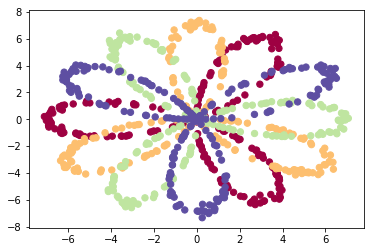

In [5]:
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral)
plt.show()

In [6]:
print(X.shape)
print(Y.shape)

(2, 800)
(1, 800)


In [7]:
n_classes = np.max(np.squeeze(Y)) + 1
Y_softmax = np.eye(n_classes)[np.squeeze(Y)]
Y_softmax = Y_softmax.T
print(Y_softmax)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [8]:
print(Y_softmax.shape)

(4, 800)


In [9]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    # creat an index list from 0 to m-1
    permutation = list(np.random.permutation(m))
    # random
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    try:
        num_complete_mini_batches = math.floor(m/mini_batch_size)
        pass
    except:
        import math
        num_complete_mini_batches = math.floor(m/mini_batch_size)
        pass
    # complete mini batches
    for k in range(0, num_complete_mini_batches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        pass
    # res mini batch
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_mini_batches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_mini_batches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        pass
    return mini_batches

In [10]:
mini_batches = random_mini_batches(X, Y_softmax)

In [11]:
W1 = np.random.randn(25, 2) * np.sqrt(2 / 2)
b1 = np.zeros((25, 1))
W2 = np.random.randn(12, 25) * np.sqrt(2 / 25)
b2 = np.zeros((12, 1))
W3 = np.random.randn(4, 12) * np.sqrt(2 / 12)
b3 = np.zeros((4, 1))

In [12]:
d1 = DotGate()
z1 = BiasGate()
a1 = ReluGate()
d2 = DotGate()
z2 = BiasGate()
a2 = ReluGate()
d3 = DotGate()
z3 = BiasGate()
a3 = SoftmaxGate()

In [13]:
def forward_propagation(X):
    # forward
    D1 = d1.forward(W1, X)
    Z1 = z1.forward(D1, b1)
    A1 = a1.forward(Z1)
    D2 = d2.forward(W2, A1)
    Z2 = z2.forward(D2, b2)
    A2 = a2.forward(Z2)
    D3 = d3.forward(W3, A2)
    Z3 = z3.forward(D3, b3)
    A3 = a3.forward(Z3)
    return A3

def compute_cost(Y, A):
    # cost
    n, m = Y.shape
    logprobs = -np.multiply(Y, np.log(A))
    cost = 1.0/m * np.nansum(logprobs)
    cost = np.squeeze(cost)
    return cost

def backward_propagation(Y, A):
    # backward
    n, m = Y.shape
    grads = {}
    dA3 = 1.0/m * -np.squeeze((Y/A))
    dZ3 = a3.backward(dA3)
    dD3, db3 = z3.backward(dZ3)
    dW3, dA2 = d3.backward(dD3)
    dZ2 = a2.backward(dA2)
    dD2, db2 = z2.backward(dZ2)
    dW2, dA1 = d2.backward(dD2)
    dZ1 = a1.backward(dA1)
    dD1, db1 = z1.backward(dZ1)
    dW1, _ = d1.backward(dD1)
    grads['dW1'] = dW1
    grads['db1'] = db1
    grads['dW2'] = dW2
    grads['db2'] = db2
    grads['dW3'] = dW3
    grads['db3'] = db3
    return grads

def update_parameters(grads, learning_rate):
    global W1, b1, W2, b2, W3, b3
    # update
    W3 = W3 - learning_rate*grads['dW3']
    b3 = b3 - learning_rate*grads['db3']
    W2 = W2 - learning_rate*grads['dW2']
    b2 = b2 - learning_rate*grads['db2']
    W1 = W1 - learning_rate*grads['dW1']
    b1 = b1 - learning_rate*grads['db1']
    pass

In [14]:
mini_batch_costs = []
costs = []
lr = 0.03
seed = 0
for i in range(2500):
    cost = 0.0
    seed = seed + 1
    mini_batches = random_mini_batches(X, Y_softmax, seed=seed)
    for mini_batch in mini_batches:
        (minibatch_X, minibatch_Y) = mini_batch
        _, m_mini_batch = minibatch_X.shape
        # forward
        A3 = forward_propagation(minibatch_X)
        # cost
        mini_batch_cost = compute_cost(minibatch_Y, A3)
        mini_batch_costs.append(mini_batch_cost)
        cost += m_mini_batch * mini_batch_cost
        # backward
        grads = backward_propagation(minibatch_Y, A3)
        # update
        update_parameters(grads, learning_rate=lr)
        pass
    _, m = X.shape
    cost = cost / m
    costs.append(cost)
    if i%100 == 0 :
        print('Cost after epoch ' + str(i) + ': ' + str(cost))
        pass
    pass

Cost after epoch 0: 1.6191111889055585
Cost after epoch 100: 0.7114739544664265
Cost after epoch 200: 0.7014041396647619
Cost after epoch 300: 0.6890116444803422
Cost after epoch 400: 0.6676410572532199
Cost after epoch 500: 0.6650141032526489
Cost after epoch 600: 0.6419827940607745
Cost after epoch 700: 0.6028141702548389
Cost after epoch 800: 0.5571269942305854
Cost after epoch 900: 0.5331774170990434
Cost after epoch 1000: 0.4735401751293922
Cost after epoch 1100: 0.42107085761326807
Cost after epoch 1200: 0.41651434361062917
Cost after epoch 1300: 0.43499190269999494
Cost after epoch 1400: 0.4128716671307729
Cost after epoch 1500: 0.38050786699009004
Cost after epoch 1600: 0.325910837264485
Cost after epoch 1700: 0.3449494810448533
Cost after epoch 1800: 0.34782335567232003
Cost after epoch 1900: 0.29914336141285064
Cost after epoch 2000: 0.2919714035847661
Cost after epoch 2100: 0.29862376515152966
Cost after epoch 2200: 0.2606254510859013
Cost after epoch 2300: 0.288212668344167

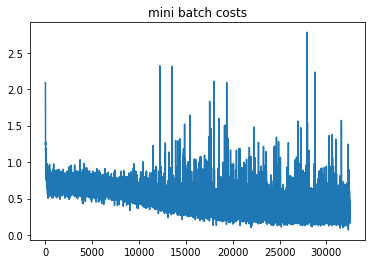

In [15]:
plt.plot(mini_batch_costs)
plt.title('mini batch costs')
plt.show()

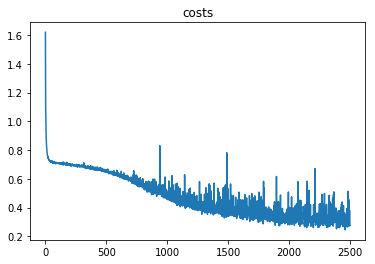

In [16]:
plt.plot(costs)
plt.title('costs')
plt.show()

In [17]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [18]:
def predict(X):
    n, m = X.shape
    # forward
    A3 = forward_propagation(X)
    predictions = np.squeeze(np.argmax(A3, axis=0))
    return predictions

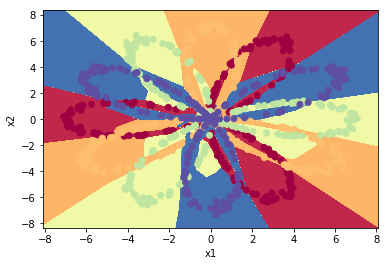

In [19]:
plot_decision_boundary(lambda x: predict(x.T), X, Y[0, :])